# Load packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
import os

# Making MERFISH object

In [12]:
counts = sc.read_csv('../data/MERFISH/raw/single_cell_raw_counts.csv', first_column_names=True)
coords = pd.read_csv('../data/MERFISH/raw/cell_metadata.csv', index_col = 0)
coords = coords.loc[coords['status']=='ok',['global_y','global_x']]
coords['global_y'] = -1 * coords['global_y'] 
coords.index = coords.index.astype('str')
adata_w13 = counts[coords.index, :]
adata_w13.obsm["spatial"] = coords
adata_w13.obs['sample_id'] = 'R98_S13'

In [3]:
# plt.hist(adata_w13.obs['n_counts'], bins=50)

In [4]:
sc.pp.filter_cells(adata_w13, min_counts=5)

In [5]:
# Preprocessin and dimensionality reduction
sc.pp.normalize_per_cell(adata_w13)
sc.pp.log1p(adata_w13)
sc.pp.pca(adata_w13)
sc.pp.neighbors(adata_w13)
sc.tl.umap(adata_w13)

# Cluster cells and annotate cell types

In [6]:
sc.tl.leiden(adata_w13, key_added="leiden", resolution=2)

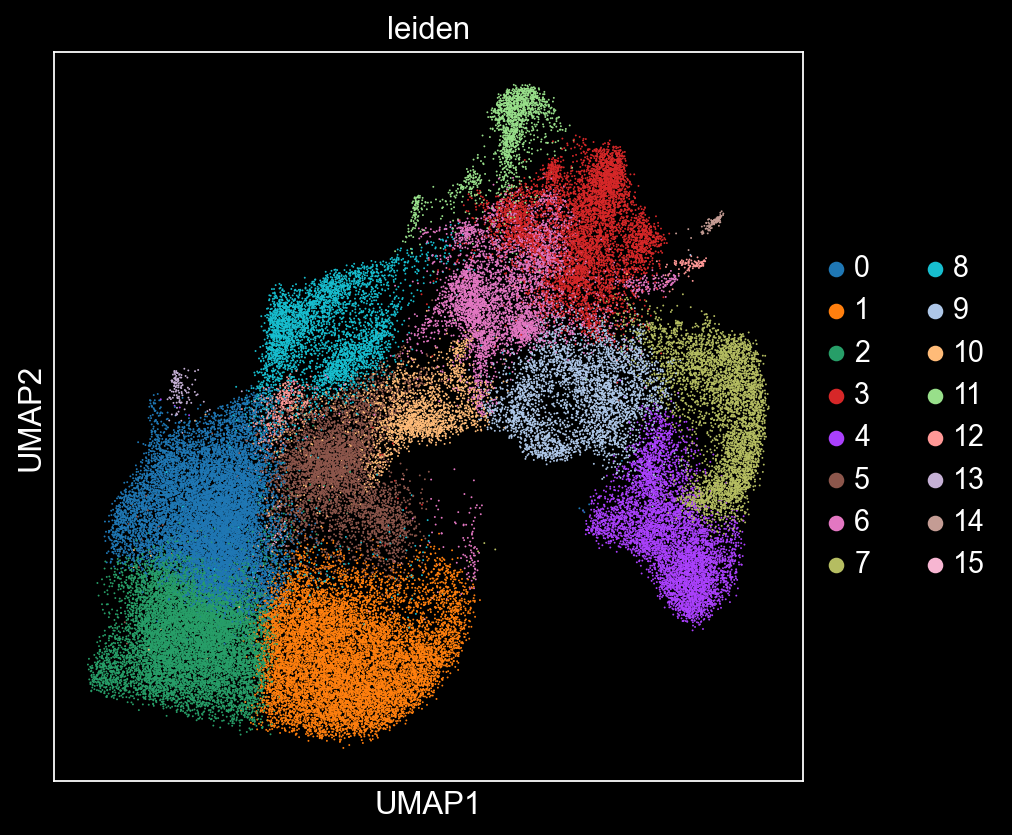

In [7]:
# Plot UMAP embedding
sc.set_figure_params(figsize=[6,6])
plt.style.use('dark_background')
sc.pl.umap(adata_w13, color="leiden", size=3)
plt.style.use('default')

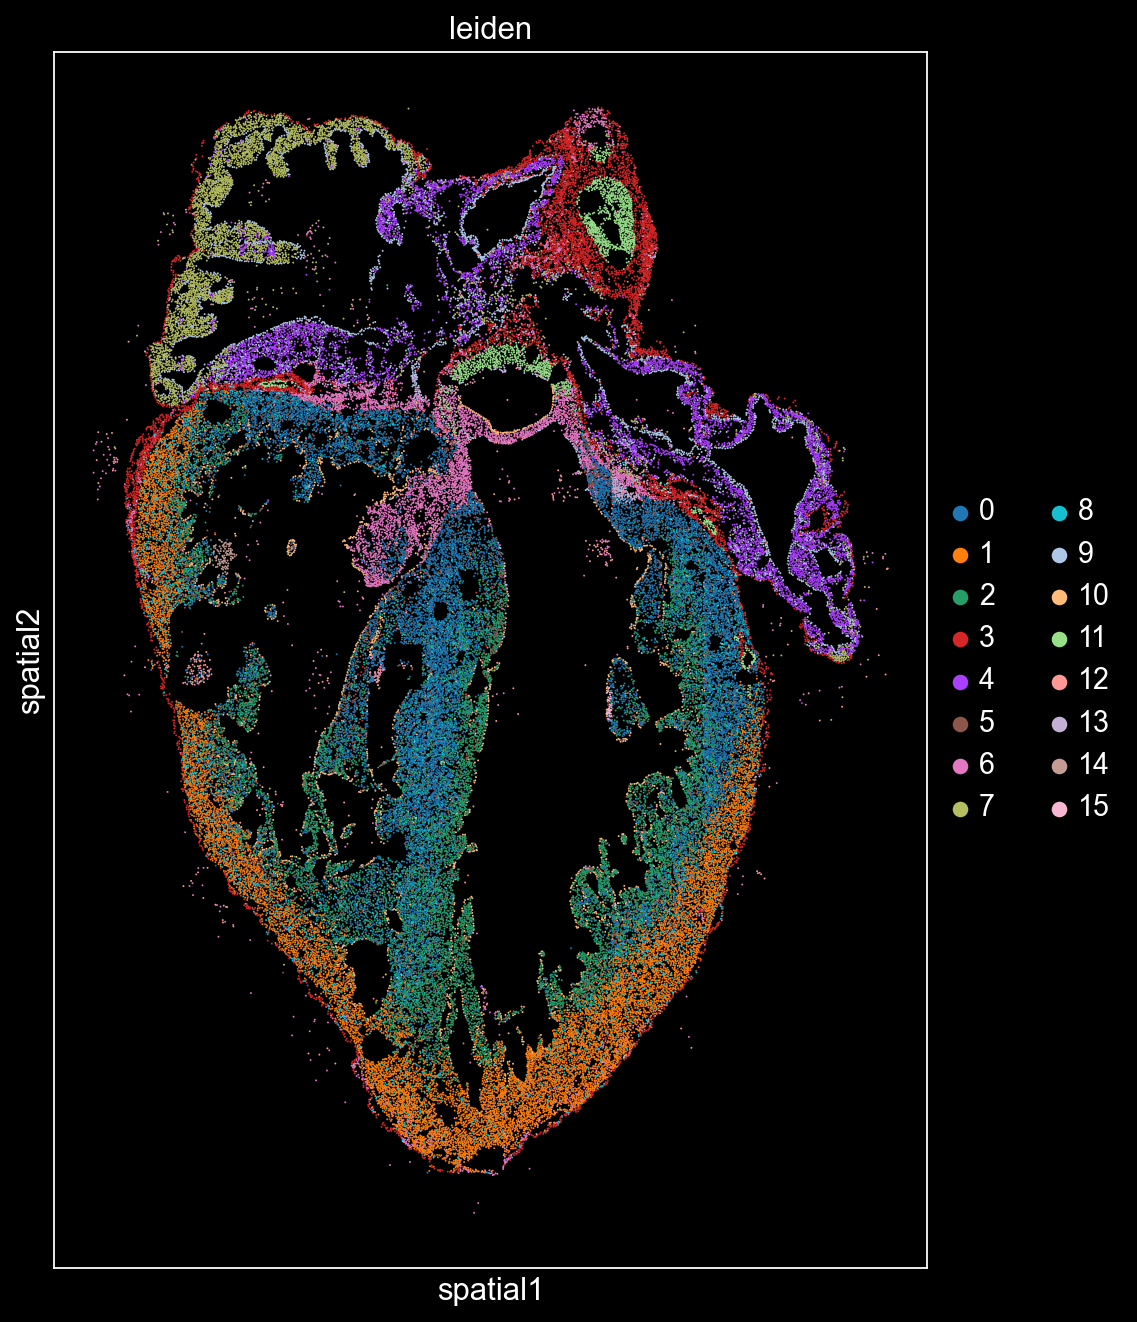

In [8]:
# Plot spatial embedding
sc.set_figure_params(figsize=[7,10])
plt.style.use('dark_background')
sc.pl.embedding(adata_w13, basis="spatial", size=3, color = 'leiden')
plt.style.use('default')

In [ ]:
# annotate clusters
cluster_annotations = {'0':'Compact vCM', '1':'Compact vCM', '2':'Trabecular vCM', '3':'remove', '4':'vFibro',
                       '5':'Compact vCM', '6':'Proliferating vCM', '7':'VIC', '8':'EPDC', '9':'aCM-LA', '10':'avCM',
                       '11':'VE', '12':'aCM-RA', '13':'vEndocardial', '14':'Compact vCM',
                       '15':'aFibro', '16':'aCM-RA', '17':'Pericyte', '18':'aCM-RA', '19':'EPDC',
                       '20':'VSMC', '21':'aEndocardial', '22':'IFT-like', '23':'remove', '24':'Neuronal-like',
                       '25':'Epicardial', '26':'remove', '27':'VSMC', '28':'remove', '29':'remove'}
adata_merfish.obs['celltype'] = adata_merfish.obs['leiden'].replace(cluster_annotations)

adata_merfish_filtered = adata_merfish[adata_merfish.obs['celltype']!='remove']

In [14]:
# Write MERFISH scanpy object to file
adata_w13.write('../data/MERFISH/scanpy_obj/merfish_w13_S13.h5ad')

... storing 'sample_id' as categorical


# Load MERFISH object

In [2]:
adata_merfish = sc.read('../data/MERFISH/scanpy_obj/merfish_w13_S13_celltype.h5ad')

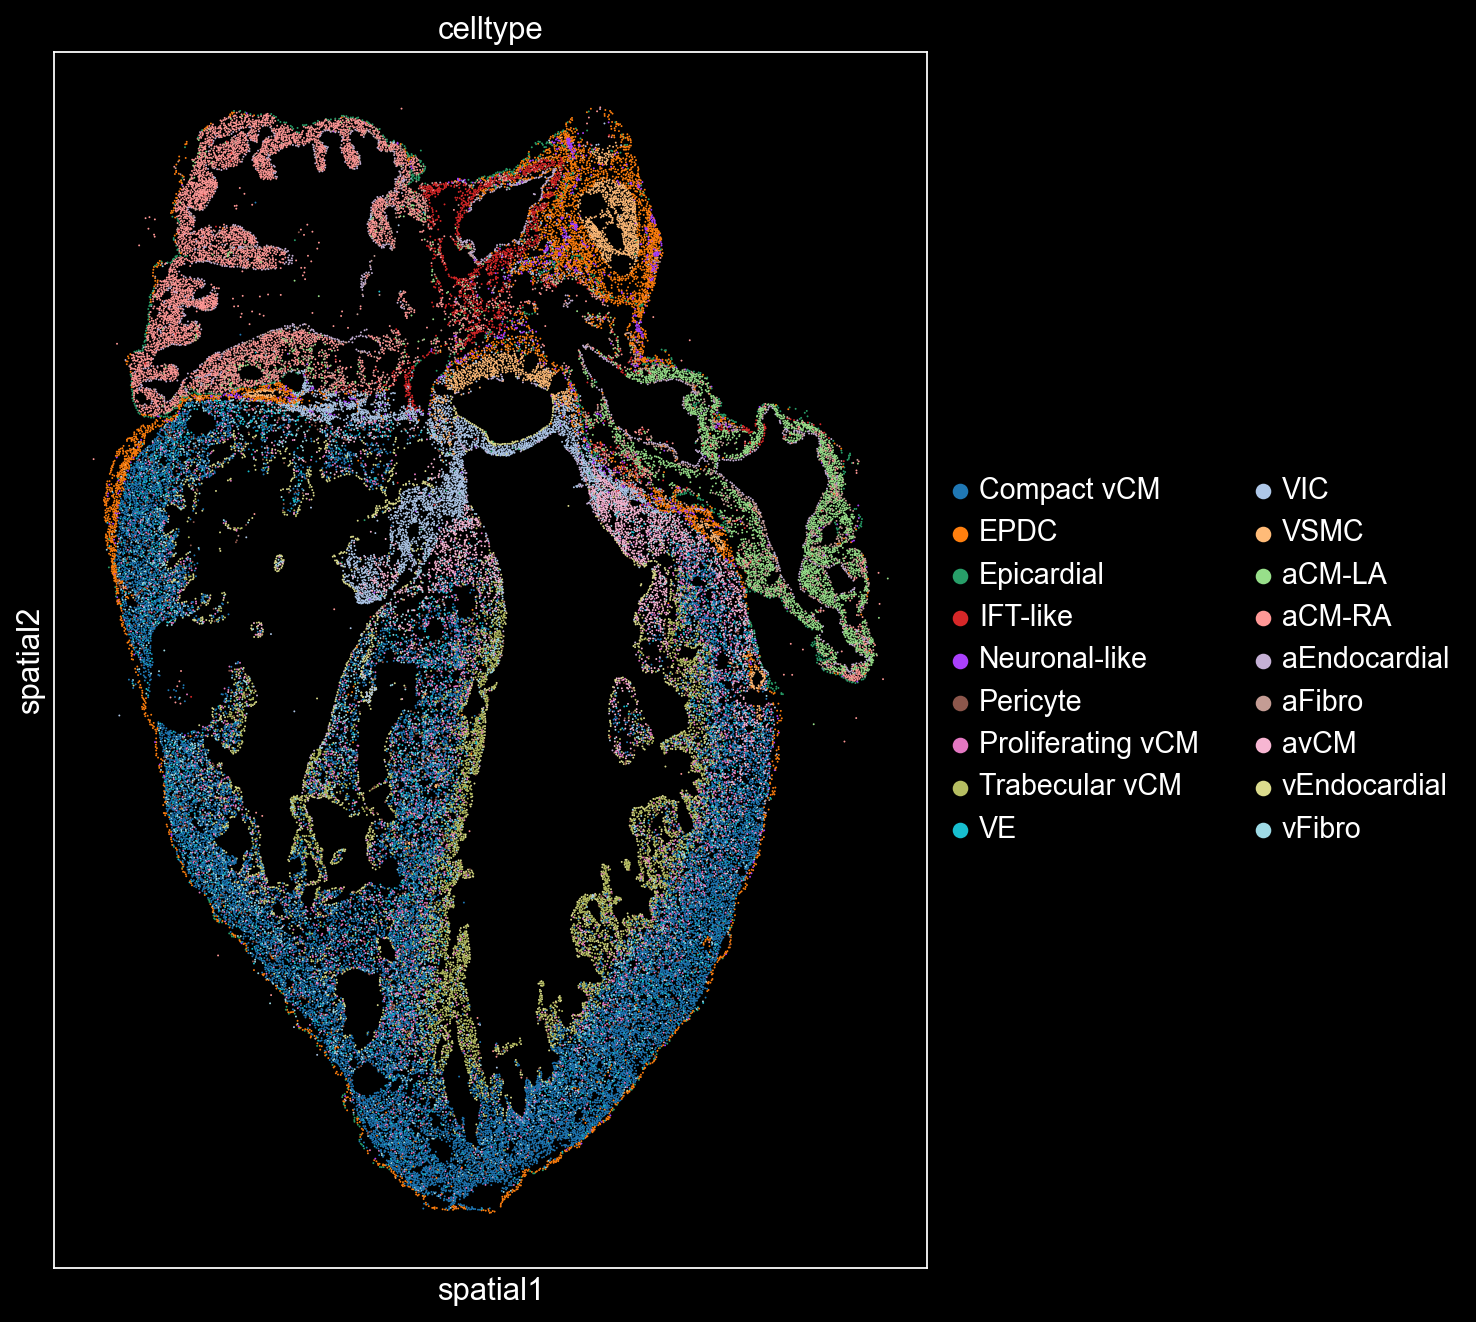

In [9]:
# Plot spatial embedding
sc.set_figure_params(figsize=[7,10])
plt.style.use('dark_background')
sc.pl.embedding(adata_merfish, basis="spatial", size=3, color = 'celltype')
plt.style.use('default')

# Community identification

## Calculate 'zone' cell type counts

In [12]:
celltype_key = 'celltype'
for radius in [25,50,75,100,125,150,175,200,225,250,275,300]:
    print(radius)
    
    for sample in ['R98_S13']:
        print(sample)

        # subset to a section, find
        adata_merfish_section = adata_merfish[adata_merfish.obs['sample_id']==sample]
        # find the neighboring cells in the 'zone' around each cell
        point_tree = sp.spatial.cKDTree(adata_merfish_section.obsm['spatial'])
        neigh_inds_list = point_tree.query_ball_point(adata_merfish_section.obsm['spatial'], radius)
        neigh_celltype_df = pd.DataFrame(adata_merfish_section.obs[celltype_key][neigh_inds_list[0]].value_counts())
            
        # quantify the proportion of cell type in each zone
        neigh_celltype_list = []
        for i in tqdm(range(len(neigh_inds_list))):
            neigh_inds = neigh_inds_list[i]
            celltype_counts = pd.DataFrame(adata_merfish_section.obs[celltype_key][neigh_inds].value_counts())
            neigh_celltype_list.append(celltype_counts)
        neigh_celltype_df = pd.concat(neigh_celltype_list, axis=1)
            
        neigh_celltype_df.columns = adata_merfish_section.obs.index
        neigh_celltype_df = neigh_celltype_df.T
        
        neigh_celltype_df = neigh_celltype_df.fillna(0.0).astype('int')
    
        # write 'zone' cell type counts to file
        neigh_celltype_df.to_csv('/volume/Projects/Heart_MERFISH_analysis/data/MERFISH/zone_counts/' + sample + '/merfish_neigh_' + celltype_key +'_counts_radius_' + str(radius) + '.csv')

25
R98_S13


100%|██████████| 68172/68172 [01:05<00:00, 1036.96it/s]


50
R98_S13


100%|██████████| 68172/68172 [01:05<00:00, 1045.66it/s]


75
R98_S13


100%|██████████| 68172/68172 [01:07<00:00, 1009.00it/s]


100
R98_S13


100%|██████████| 68172/68172 [01:11<00:00, 954.27it/s] 


125
R98_S13


100%|██████████| 68172/68172 [01:12<00:00, 938.16it/s] 


150
R98_S13


100%|██████████| 68172/68172 [01:08<00:00, 991.06it/s] 


175
R98_S13


100%|██████████| 68172/68172 [01:09<00:00, 984.74it/s] 


200
R98_S13


100%|██████████| 68172/68172 [01:10<00:00, 963.10it/s] 


225
R98_S13


100%|██████████| 68172/68172 [01:12<00:00, 940.46it/s] 


250
R98_S13


100%|██████████| 68172/68172 [01:14<00:00, 912.64it/s] 


275
R98_S13


100%|██████████| 68172/68172 [01:17<00:00, 882.88it/s] 


300
R98_S13


100%|██████████| 68172/68172 [01:21<00:00, 841.40it/s] 


## Choosing number of clusters

In [14]:
radius = 150

neigh_celltype_df = pd.read_csv('../data/MERFISH/zone_counts/R98_S13/merfish_neigh_celltype_counts_radius_' + str(radius) + '.csv', index_col=0)
# neigh_celltype_df = neigh_celltype_df.append(pd.read_csv('../data/MERFISH/zone_counts/R78_4C12/merfish_neigh_celltype_counts_radius_' + str(radius) + '.csv', index_col=0))
neigh_celltype_df.index = neigh_celltype_df.index.astype('str')
sil_score_dict = {}

for k in tqdm([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(neigh_celltype_df)
    score = silhouette_score(X = neigh_celltype_df.to_numpy(),
                             sample_size = 50000,
                             labels = kmeans.labels_.astype('str'))
    sil_score_dict[k] = score

100%|██████████| 14/14 [06:37<00:00, 28.42s/it]


<ipython-input-15-e0d5ad0f77d5>:4: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


[Text(0, 0.5, 'Average silhoute score')]

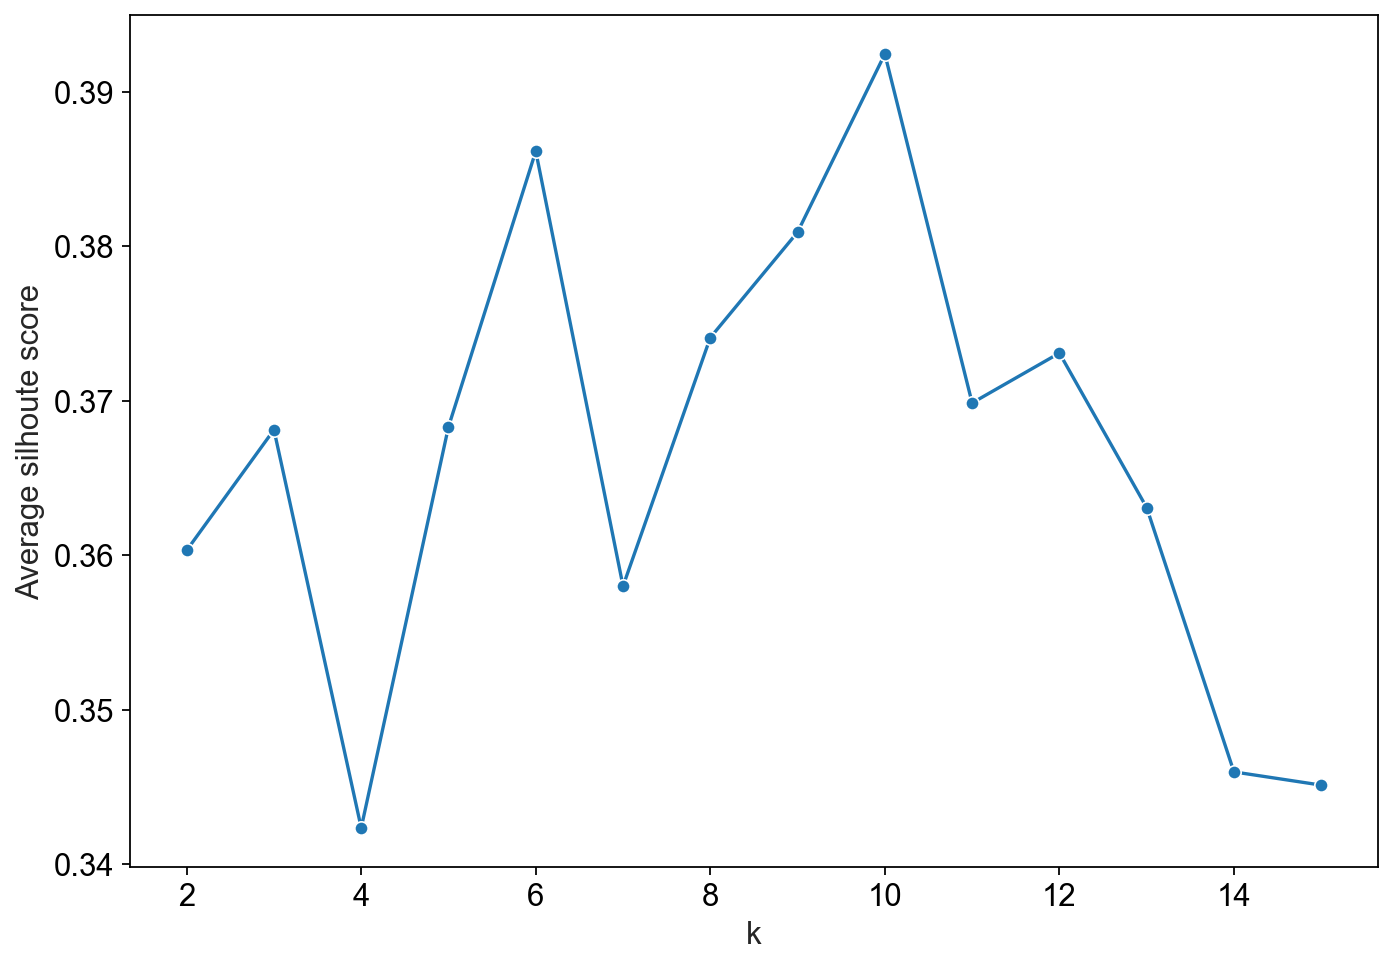

In [15]:
sil_score_df = pd.DataFrame({'k':list(sil_score_dict.keys()), 'sil_score':list(sil_score_dict.values())})
sns.set_style("ticks")
sc.set_figure_params(figsize=[10,7])
plt.grid(b=None)
g = sns.lineplot(data=sil_score_df, x="k", y="sil_score", marker="o")
g.set(ylabel = "Average silhoute score")
# plt.savefig('/volume/Notebooks/sil_score.pdf', bbox_inches='tight')

## Cluster 'zones'

In [3]:
radius = 150
celltype_key = 'celltype'

# Read in 'zone' cell type counts for each section
neigh_celltype_df = pd.read_csv('../data/MERFISH/zone_counts/R98_S13/merfish_neigh_celltype_counts_radius_' + str(radius) + '.csv', index_col=0)
# neigh_celltype_df = neigh_celltype_df.append(pd.read_csv('/volume/Projects/Heart_MERFISH_analysis/data/MERFISH/zone_counts/R78_4C12/merfish_neigh_' + celltype_key + '_counts_radius_' + str(radius) + '.csv', index_col=0))

# Scale cell type counts for each 'zone'
neigh_celltype_df = pd.DataFrame(StandardScaler().fit_transform(neigh_celltype_df),
                                 index = neigh_celltype_df.index,
                                 columns = neigh_celltype_df.columns)

neigh_celltype_df.columns = neigh_celltype_df.columns.astype(str)
neigh_celltype_df.index = neigh_celltype_df.index.astype(str)

In [9]:
# K-means cluster 'zone' cell type proportions
k = 7
kmeans = KMeans(n_clusters=k, random_state=0).fit(neigh_celltype_df)

adata_merfish.obs.loc[neigh_celltype_df.index,'zone_cluster'] = kmeans.labels_.astype('str')

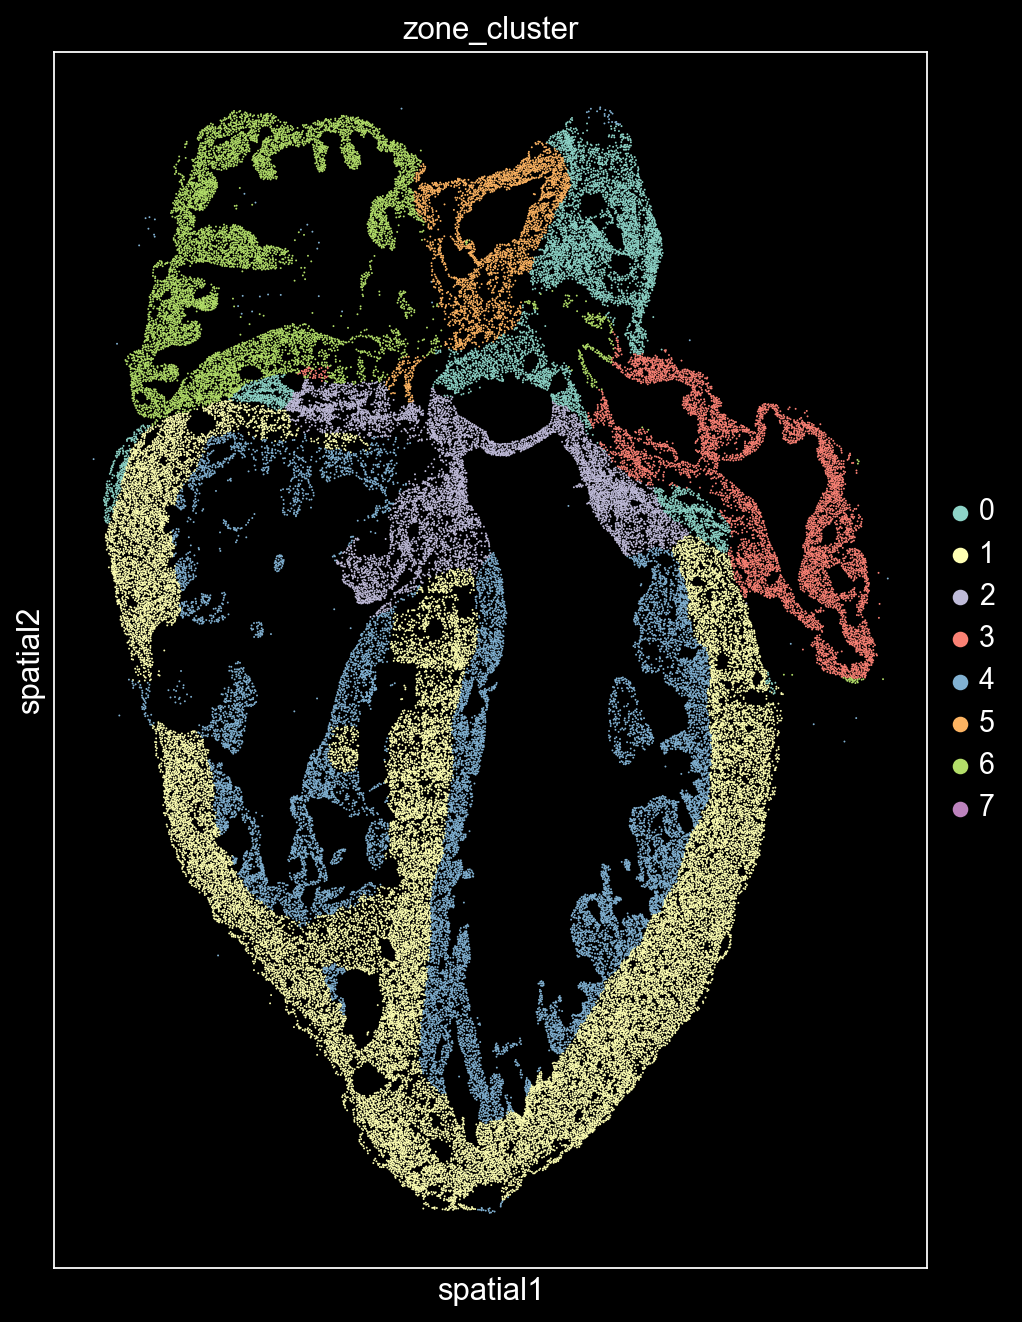

In [10]:
# Plot zone clusters spatially
sc.set_figure_params(figsize=[7,10])
plt.style.use('dark_background')
sc.pl.embedding(adata_merfish, basis="spatial", color="zone_cluster", size=3)
plt.style.use('default')

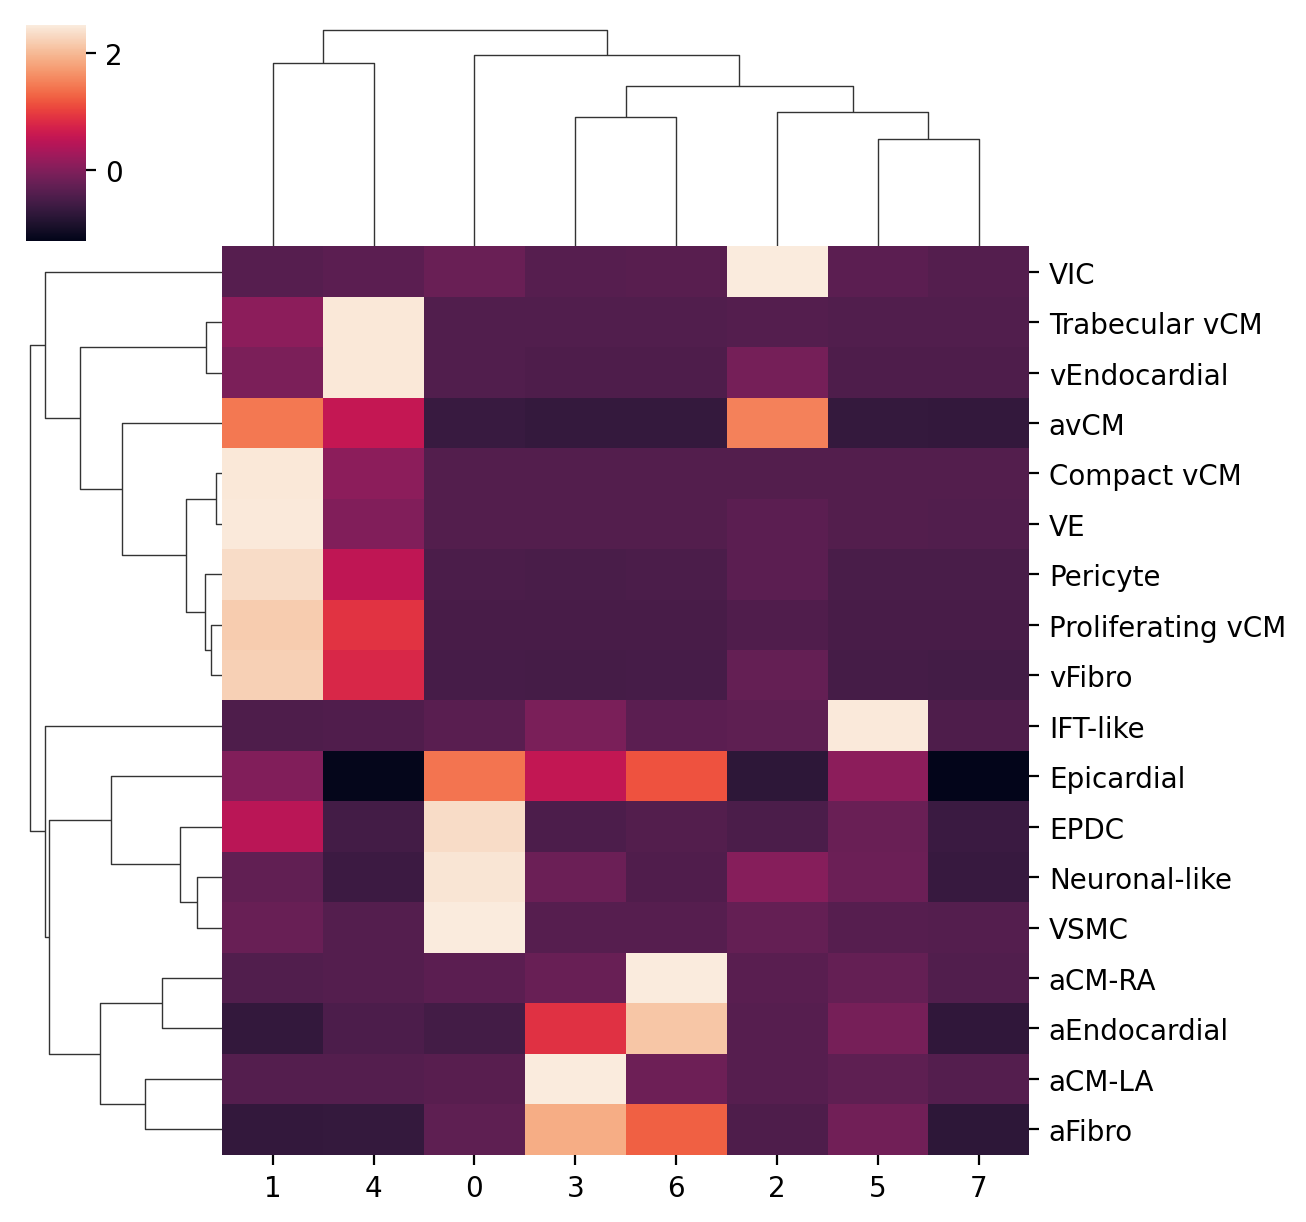

In [11]:
# Generate a heatmap to visualize the cell type contribution for each cluster
df = adata_merfish.obs.groupby([celltype_key,'zone_cluster']).size().unstack(fill_value=0).to_numpy()
plot_df = pd.DataFrame(df, 
                       index=adata_merfish.obs[celltype_key].cat.categories, 
                       columns=adata_merfish.obs['zone_cluster'].cat.categories)
plot_df_norm_row = plot_df.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
g = sns.clustermap(plot_df_norm_row)
g.fig.set_size_inches(6,6)

## Annotate clusters

In [ ]:
# annotate clusters (CHANGE CLUSTER MAPPING)
zone_cluster_annotations = {'0':'IFT', '1':'Inner Ventricle', '2':'Left Atria', '3':'Mid Ventricle', 
                           '4':'OFT', '5':'Outer Ventricle', '6':'Subepicardial', '7':'Right Atria', 
                           '8':'Valve', '9':'???'}
adata_merfish.obs['communities'] = adata_merfish.obs['zone_cluster'].replace(zone_cluster_annotations)